In [10]:
import os
import re
import json
import errno
import shutil
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from shutil import rmtree
from zipfile import ZipFile
from tqdm import tqdm
from glob import iglob
from os.path import join as pjoin

warnings.filterwarnings(action='ignore') 

In [11]:
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise
def del_folder(path):
    try:
        rmtree(path)
    except:
        pass

def read_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def write_json(save_path, json_obj):
    with open(save_path, 'w', encoding='utf-8') as make_file:
        json.dump(json_obj, make_file, indent="\t")
    return

def get_extension(file_path):
    return file_path.split(".")[-1]


In [12]:
DATA_DIR = "/data/ai_hub"
RAW_DATA_DIR = pjoin(DATA_DIR, "raw")

In [13]:
ANNOT_DIR = pjoin(DATA_DIR, "annotations")
IMAGE_DIR = pjoin(DATA_DIR, "images")

In [14]:
PROC_DATA_DIR = pjoin(DATA_DIR, "proc")
mkdir_p(PROC_DATA_DIR)

PROC_ANNOT_DIR = pjoin(PROC_DATA_DIR, "annotations")
PROC_IMAGE_DIR = pjoin(PROC_DATA_DIR, "images")
mkdir_p(PROC_ANNOT_DIR)
mkdir_p(PROC_IMAGE_DIR)

In [15]:
FEMALE_ID = '┐⌐'

In [16]:
emotion_kor_to_eng = {
    "기쁨" : "happy",
    "당황" : "embarrassing",
    "분노" : "angry",
    "불안" : "unrest",
    "상처" : "hurt",
    "슬픔" : "sad",
    "중립" : "neutral",
}

### **Decompress zip files**

In [ ]:
list(iglob(pjoin(RAW_DATA_DIR, "*.zip")))

In [ ]:
del_folder(ANNOT_DIR)
mkdir_p(ANNOT_DIR)

del_folder(IMAGE_DIR)
mkdir_p(IMAGE_DIR)

In [ ]:
zip_file_list = list(iglob(pjoin(RAW_DATA_DIR, "*.zip")))
for zip_p in tqdm(zip_file_list, total=len(zip_file_list), desc="decompress zipfiles"):
    zip_filename = zip_p.split(os.sep)[-1].split(".zip")[0]
    
    emotion, subset = zip_filename.split("_")[1], zip_filename.split("_")[2]
    
    if '라벨' in zip_filename:
        tgt_dir = pjoin(ANNOT_DIR, emotion_kor_to_eng[emotion])
    else:
        tgt_dir = pjoin(IMAGE_DIR, emotion_kor_to_eng[emotion])

    with ZipFile(zip_p, 'r') as zip_ref:
        zip_ref.extractall(tgt_dir)


### **Rename files**

In [ ]:
def remove_special_chars(text):
    return re.sub('[^0-9a-zA-Z\_\.\-]', '', text)

def del_duplicated_underbar(text):
    return re.sub('[\_]+', '_', text)

In [ ]:
from shutil import move

exts = ["jpg", "jpeg"]
emotions = list(emotion_kor_to_eng.values())
for ext in exts:
    for emo in tqdm(emotions, total=len(emotions), desc=f"Rename images (*.{ext})"):
        
        image_paths = list(iglob(pjoin(IMAGE_DIR, emo, f"**/*.{ext}")))
        
        for path in tqdm(image_paths, total=len(image_paths), desc="Move images"):
            filename = path.split(os.sep)[-1].split(".")[0]

            uid, gender, age, _, _, upload_id = filename.split("_")
            gender = "female" if gender == FEMALE_ID else "male"
            new_filename = "_".join([uid, gender, age, emo, upload_id]) + f".{ext}"
            move(src=path, dst=pjoin(IMAGE_DIR, new_filename))

In [ ]:
emotions = list(emotion_kor_to_eng.values())
for emo in tqdm(emotions, total=len(emotions), desc=f"Rename annotations"):
        
    annot_paths = list(iglob(pjoin(ANNOT_DIR, emo, f"*.json")))
        
    for path in tqdm(annot_paths, total=len(annot_paths), desc="Move annotations"):
        filename = path.split(os.sep)[-1].split(".")[0]
        subset = "train" if "training" in filename else "val"

        new_filename = f"{emo}_{subset}.json"
        move(src=path, dst=pjoin(ANNOT_DIR, new_filename))    

Restructure annotation

In [19]:
for subset in ["train", "val"]:
    annot_paths = list(iglob(pjoin(ANNOT_DIR, f"*_{subset}.json")))

    subset_annot = []
    
    for path in tqdm(annot_paths, total=len(annot_paths), desc=f"Restructure {subset} annotations"):
        annots = read_json(path)
        emotion = path.split(os.sep)[-1].split("_")[0]
        
        for ann in tqdm(annots, total=len(annots), desc=""):
            item = {
                "filename" : ann["filename"],
                "emotion" : emotion,
                "gender" : "male" if ann['gender'] == "남" else "female",
                "age": ann['age'],
                "annotations": ann
            }
            subset_annot += [item]
    write_json(save_path=pjoin(ANNOT_DIR, f"{subset}.json"), json_obj=subset_annot)

Restructure val annotations: 100%|██████████| 7/7 [00:00<00:00,  9.74it/s]


In [22]:
train_annot = read_json(pjoin(ANNOT_DIR, "train.json"))
len(train_annot)

417167

### **Load Images**

In [23]:
len(list(iglob(pjoin(IMAGE_DIR, "*.*"))))

453258

In [24]:
#-*-coding:utf-8 -*-

image_list = list(iglob(pjoin(IMAGE_DIR, "*.*")))

data_rows = []
for image_path in tqdm(image_list, total=len(image_list), desc="Build image DataFrame"):
    image_name = image_path.split(os.sep)[-1]
    image_name, ext = image_name.split(".")

    if not ext in ['jpg', 'jpeg']: continue
    uid, sex, age, emotion, upload_id = image_name.split("_")
    
    row = {
        'uid': uid,
        'sex': sex,
        'age': age,
        'emotion': emotion,
        'upload_id': upload_id
    }
    data_rows += [row]
image_df = pd.DataFrame(data_rows, columns=['uid', 'sex', 'age', 'emotion', 'upload_id'])

Build image DataFrame: 100%|██████████| 453258/453258 [00:00<00:00, 713777.40it/s]


In [25]:
image_df.head()

,uid,sex,age,emotion,upload_id
0,0de90b7d70454e372b6ed56bdfdba5a10c1036514f6093...,male,20,sad,20210201134619-010-015
1,a2d78ce34b11984ce90d937cf7cc1720b8647d4c5ab25c...,female,20,sad,20201206233948-009-001
2,6036080c7e692255e0cfd6969d129abb8b5df9f83c857f...,female,40,embarrassing,20210215113102-010-012
3,cf4e7d3579d0ff6e6d7ad23fd8f679e5968e6012338d7c...,female,20,angry,20210210165111-010-003
4,d2e7527d0e3086d5df90c4607d390f218ccb93d32ea720...,female,20,hurt,20210203214029-003-005


In [26]:
len(image_df)

453257

In [27]:
len(image_df.drop_duplicates())

453257

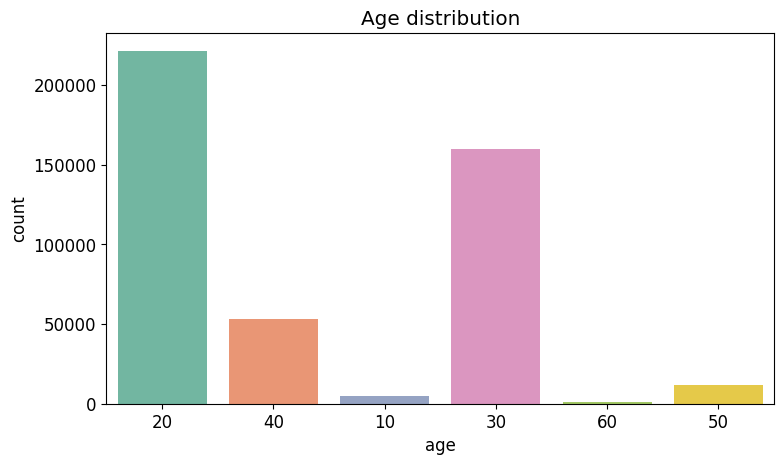

In [28]:
plt.rcParams["figure.figsize"] = (8, 5)
plt.rc('font', size=12)

fig, axarr = plt.subplots(1, 1)
sns.countplot(x=image_df["age"], ax=axarr, palette=sns.color_palette("Set2"))
axarr.set_title('Age distribution')

fig.tight_layout()
fig.subplots_adjust(top=0.88)

plt.show()

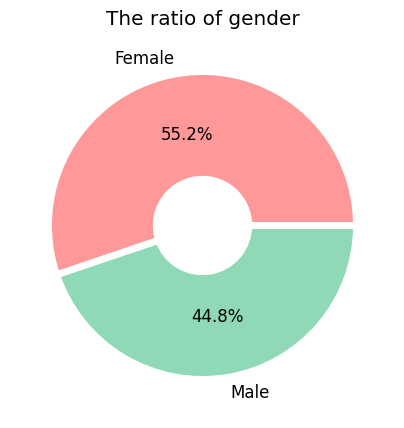

In [29]:
labels = ['Female', 'Male']
colors = ['#ff9999', '#8fd9b6']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

plt.rcParams["figure.figsize"] = (5, 5)
plt.rc('font', size=12)

# entire_data = pd.concat([train_data, test_result])
female_ratio = len(image_df[image_df["sex"]=='female']) / len(image_df)
male_ratio = len(image_df[image_df["sex"]=='male']) / len(image_df)

ratios =[female_ratio, male_ratio]
plt.pie(ratios, labels=labels, autopct='%.1f%%', shadow=False, colors=colors, wedgeprops=wedgeprops)
plt.title('The ratio of gender')

plt.show()

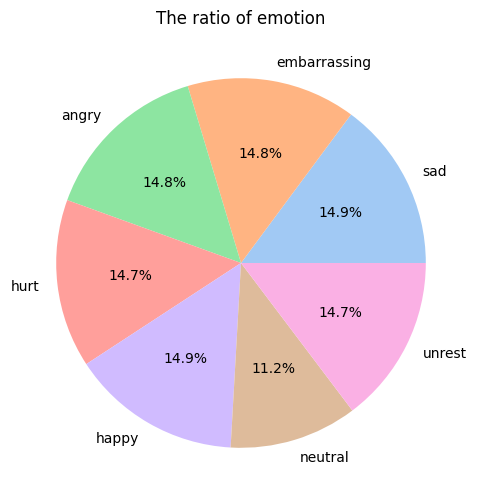

In [30]:
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
colors = sns.color_palette('pastel')[0:7]

plt.rcParams["figure.figsize"] = (6, 6)
plt.rc('font', size=10)

fig, axarr = plt.subplots(1, 1)

emotion_list = list(image_df['emotion'].unique())

ratios, labels = [], []
for emotion in emotion_list:
    ratio = len(image_df[image_df["emotion"] == emotion]) / len(image_df)
    ratios += [ratio]
    labels += [f'{emotion}']

axarr.pie(ratios, labels=labels, autopct='%.1f%%', shadow=False, colors = colors)
axarr.set_title('The ratio of emotion')

plt.show()

### **Sample dataset**

In [31]:
sample_ratio = 0.1
seed = 19

subset = pd.DataFrame(columns=['uid', 'sex', 'age', 'emotion', 'upload_id'])

for emotion in image_df['emotion'].unique():
    emotion_df = image_df[image_df['emotion'] == emotion]
    emotion_subset_df = emotion_df.sample(frac=sample_ratio, random_state=seed)
    subset = pd.concat([subset, emotion_subset_df])
subset

,uid,sex,age,emotion,upload_id
154732,2b758c5e67b331fbeef31382e60f5892036536798f362a...,male,20,sad,20201207011153-001-003
416285,43015d16922b50459eb62e3cc7efcb1a2a1a232e67faaf...,male,30,sad,20210125201928-008-002
140015,a7ec0d470482eb7dad965c5239878a80351bfc545ab380...,female,30,sad,20210126173751-010-009
177097,0a9d34ff118aca8feadb6a3f3b07e7d6f5f474b5f88c21...,female,20,sad,20201208103333-009-014
430991,6955b2914394a4d173715e0c6fd3922cb2e4397463351d...,female,20,sad,20201207101423-010-001
...,...,...,...,...,...
299281,6955b2914394a4d173715e0c6fd3922cb2e4397463351d...,female,20,unrest,20201207101517-003-002
91104,6b4bcf800a59af45665ed6475db60d144e0b682e84f534...,female,30,unrest,20201204172931-004-005
361235,65aa209849705e5d0b3b49f56673e093e6c289394307e2...,female,40,unrest,20201206125808-009-030
214949,fb7e36ab9aa3c1a2853d6956211c3a23350490e8810e41...,female,30,unrest,20201207135931-007-017


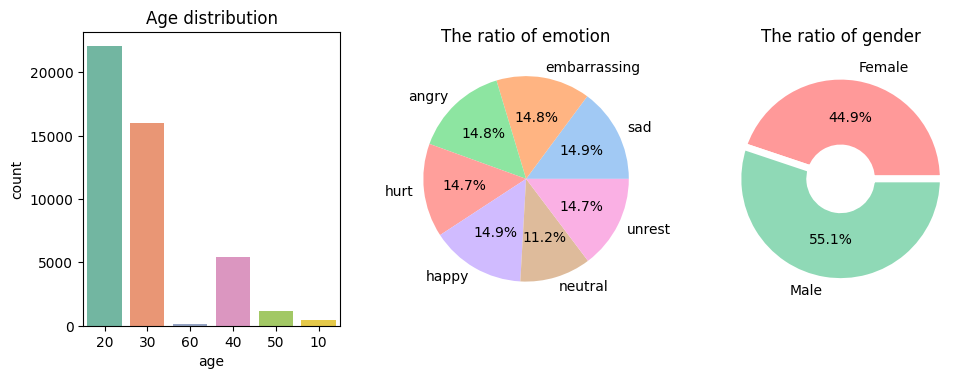

In [32]:
data = subset

wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
plt.rcParams["figure.figsize"] = (10, 4)
plt.rc('font', size=10)

fig, axarr = plt.subplots(1, 3)

# Age 분포
sns.countplot(x=data["age"], ax=axarr[0], palette=sns.color_palette("Set2"))
axarr[0].set_title('Age distribution')

fig.tight_layout()
fig.subplots_adjust(top=0.88)

# Emotion 분포
emotion_list = list(data['emotion'].unique())

ratios, labels = [], []
for emotion in emotion_list:
    ratio = len(data[data["emotion"] == emotion]) / len(data)
    ratios += [ratio]
    labels += [f'{emotion}']

axarr[1].pie(ratios, labels=labels, autopct='%.1f%%', shadow=False, colors = sns.color_palette('pastel')[0:7])
axarr[1].set_title('The ratio of emotion')

# Gender 분포
gender_list = list(data['sex'].unique())

ratios, labels = [], []
for gender in gender_list:
    ratio = len(data[data["sex"] == gender]) / len(data)
    ratios += [ratio]
    labels += [f'{gender[0].upper()}{gender[1:]}']

axarr[2].pie(ratios, labels=['Female', 'Male'], autopct='%.1f%%', \
    shadow=False, colors=['#ff9999', '#8fd9b6'], wedgeprops=wedgeprops)
axarr[2].set_title('The ratio of gender')

plt.show()

In [33]:
subset.to_csv(pjoin(IMAGE_DIR, "sampled_image.csv"), index=False, encoding="utf-8")

### **Build Sample dataset**

In [34]:
sample_image = pd.read_csv(pjoin(IMAGE_DIR, "sampled_image.csv"))

In [38]:
annot_angry_train = read_json(pjoin(ANNOT_DIR, "angry_train.json"))
annot_angry_train

[{'filename': 'ed8e05a7770502606d8278a279c624e4fb7e681fd09766c71b4c8eb8d3af7a5b_여_30_분노_상업시설&점포&시장_20201206210735-003-003.jpg',
  'gender': '여',
  'age': 30,
  'isProf': '전문인',
  'faceExp_uploader': '분노',
  'bg_uploader': '상업시설/점포/시장',
  'annot_A': {'boxes': {'maxX': 1780.9736000000003,
    'maxY': 1379.6985,
    'minX': 957.0113,
    'minY': 304.80539999999996},
   'faceExp': '분노',
   'bg': '행사/사무공간'},
  'annot_B': {'boxes': {'maxX': 1763.3890909090908,
    'maxY': 1395.8249503030304,
    'minX': 978.3224242424243,
    'minY': 335.6163103030303},
   'faceExp': '상처',
   'bg': '행사/사무공간'},
  'annot_C': {'boxes': {'maxX': 1765.1136050384655,
    'maxY': 1393.0530088813596,
    'minX': 975.5331394461655,
    'minY': 339.33831819983544},
   'faceExp': '분노',
   'bg': '행사/사무공간'}},
 {'filename': '6ea444752308b9fc4ce87b2dc63c1341da53b94bc7804a5ea3106732950ca1ac_여_20_분노_도심 환경_20201207140412-008-022.jpg',
  'gender': '여',
  'age': 20,
  'isProf': '전문인',
  'faceExp_uploader': '분노',
  'bg_uploader'

In [39]:
len(annot_angry_train)

59696

In [40]:
sample_image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45326 entries, 0 to 45325
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   uid        45326 non-null  object
 1   sex        45326 non-null  object
 2   age        45326 non-null  int64 
 3   emotion    45326 non-null  object
 4   upload_id  45326 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [41]:
def is_valid_filename(filename, sampled_image):
    uid, sex, age, emotion, _, upload_id = filename.split("_")
    
    sex = 'female' if sex == '여' else 'male'
    emotion = emotion_kor_to_eng[emotion]
    
    check_obj = sampled_image[(sampled_image['uid']==uid) & \
                (sampled_image['sex']==sex) & \
                (sampled_image['age']==int(age)) & \
                (sampled_image['emotion']==emotion) & \
                (sampled_image['upload_id']==upload_id)]
    return len(check_obj) > 0

In [42]:
emotions = list(emotion_kor_to_eng.values())

In [43]:
for emotion in tqdm(emotions, total=len(emotions), desc="Save sampled annotations"):
    annot_paths = list(iglob(pjoin(ANNOT_DIR, f"{emotion}_*.json")))

    for annot_p in annot_paths:
        subset_annot = read_json(annot_p)
        annot_name = annot_p.split(os.sep)[-1]
        
        sampled_subset_annot = []
        for ann in tqdm(subset_annot, total=len(subset_annot), desc=f"{annot_name}"):
            if is_valid_filename(ann['filename'].split(".")[0], sample_image):
                sampled_subset_annot += [ann]
        
        write_json(save_path=pjoin(PROC_ANNOT_DIR, annot_name), json_obj=sampled_subset_annot)

Save sampled annotations: 100%|██████████| 7/7 [1:08:50<00:00, 590.04s/it]


In [ ]:
test_raw_path = list(iglob(pjoin(ANNOT_DIR, "angry", "*.json")))[0]
test_raw_data = read_json(test_raw_path)

In [ ]:
len(test_raw_data)

In [ ]:
test_path = list(iglob(pjoin(PROC_ANNOT_DIR, "angry", "*.json")))[0]
test_data = read_json(test_path)

In [ ]:
len(test_data)